# **VGG16 and CIFAR10**

# Importing Libraries

In [ ]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import cv2
import random
import pickle
import time
from sklearn import preprocessing
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten, Conv2D, MaxPooling2D, Rescaling
from tensorflow.keras.callbacks import TensorBoard
from tensorflow import keras
from sklearn.metrics import confusion_matrix
import zipfile 
import seaborn as sns

# Connecting Kaggle and Downloading Dataset

In [ ]:
#1. Install the Kaggle library
! pip install kaggle

#2. Make a directory named “.kaggle”
! mkdir ~/.kaggle

#3. Copy the “kaggle.json” into this new directory
! cp kaggle.json ~/.kaggle/

#4. Allocate the required permission for this file.
! chmod 600 ~/.kaggle/kaggle.json

#The colab notebook is now ready to download datasets from Kaggle.

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
mkdir: cannot create directory ‘/root/.kaggle’: File exists


In [ ]:
! pwd

/content


In [ ]:
#download kaggle dataset
! kaggle datasets download swaroopkml/cifar10-pngs-in-folders

cifar10-pngs-in-folders.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
zip_ref = zipfile.ZipFile('/content/cifar10-pngs-in-folders.zip', 'r') # Opens the zip file in read mode
zip_ref.extractall('/content') # Extracts the files into the /content folder
zip_ref.close()

In [ ]:
# 5k test, 20k train images

PATH_TRAIN = "/content/cifar10/cifar10/train"
PATH_VALID = None
PATH_TEST = "/content/cifar10/cifar10/test"

In [ ]:
image_size = (224, 224)
batch_size = 32

In [ ]:
train_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TRAIN,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=42,
    validation_split=0.3,
    subset="training",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 50000 files belonging to 10 classes.
Using 35000 files for training.


In [ ]:
valid_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TRAIN,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=24,
    validation_split=0.3,
    subset="validation",
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 50000 files belonging to 10 classes.
Using 15000 files for validation.


In [ ]:
test_ds = tf.keras.utils.image_dataset_from_directory(
    PATH_TEST,
    labels='inferred',
    label_mode='categorical',
    class_names=None,
    color_mode='rgb',
    batch_size=batch_size,
    image_size=image_size,
    shuffle=True,
    seed=55,
    validation_split=None,
    subset=None,
    interpolation="bilinear",
    follow_links=False,
    crop_to_aspect_ratio=False,
)

Found 10000 files belonging to 10 classes.


In [ ]:
class_names = train_ds.class_names
print(class_names)

['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']


In [ ]:
for image_batch, labels_batch in train_ds:
    print(image_batch.shape)
    print(labels_batch.shape)
    break

(32, 224, 224, 3)
(32, 10)


# Transfer Model1 - VGG 16 (2 layers trainable)

## What is VGG16 used for
VGG16 is object detection and classification algorithm which is able to classify 1000 images of 1000 different categories with 92.7% accuracy. It is one of the popular algorithms for image classification and is easy to use with transfer learning. (https://medium.com/@mygreatlearning/everything-you-need-to-know-about-vgg16-7315defb5918)

## Transfer Model Build and Train

### The model below (model_vgg_16) is just like VGG 16 and its weights from imaget but the output layer(1000 nodes-class) of vgg 16 is dropped and new 2 layers added at the end of vgg 16. First added layer is 1024 dense and second (will be the last, output layer) is 10 dense. This is because 10 class-classification will be processed. Except these two last layers, other layers will be non-trainable. Only last two layers will be trained, because vgg 16 was already trained for 1000 classes. This non-trainable layers provide us speed. Check model.summary()

In [ ]:
IMG_SHAPE = (224, 224, 3)

VGG16_MODEL = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

#By specifying the include_top=False argument, you load a network that doesn’t include the classification layers.


model_vgg_16 = tf.keras.Sequential([
    keras.Input(IMG_SHAPE),
    tf.keras.layers.Rescaling(1./255)
])

for layer in VGG16_MODEL.layers[:-1]: # go through until last layer
    model_vgg_16.add(layer)
    layer.trainable = False

    
model_vgg_16.add(Dense(1024))
model_vgg_16.add(Activation("relu"))

model_vgg_16.add(Dense(10))
model_vgg_16.add(Activation("softmax"))


#tensorboard_vgg_16 = TensorBoard(log_dir=f"logs/vgg_16 batch={batch_size} epoch={Epoch}")

model_vgg_16.compile(optimizer="Adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])


model_vgg_16.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1

In [ ]:
Epoch = 15

In [ ]:
history = model_vgg_16.fit(train_ds, epochs=Epoch, validation_data=valid_ds) #callbacks=[tensorboard_vgg_16]

Epoch 1/15
1094/1094 [==============================] - 257s 230ms/step - loss: 1.8175 - accuracy: 0.3473 - val_loss: 1.5815 - val_accuracy: 0.4326
Epoch 2/15
1094/1094 [==============================] - 249s 227ms/step - loss: 1.5282 - accuracy: 0.4458 - val_loss: 1.4524 - val_accuracy: 0.4752
Epoch 3/15
1094/1094 [==============================] - 249s 227ms/step - loss: 1.4395 - accuracy: 0.4790 - val_loss: 1.4091 - val_accuracy: 0.4798
Epoch 4/15
1094/1094 [==============================] - 248s 227ms/step - loss: 1.3789 - accuracy: 0.5064 - val_loss: 1.3519 - val_accuracy: 0.5173
Epoch 5/15
1094/1094 [==============================] - 249s 227ms/step - loss: 1.3362 - accuracy: 0.5213 - val_loss: 1.2669 - val_accuracy: 0.5552
Epoch 6/15
1094/1094 [==============================] - 249s 227ms/step - loss: 1.3105 - accuracy: 0.5327 - val_loss: 1.2475 - val_accuracy: 0.5570
Epoch 7/15
1094/1094 [==============================] - 249s 227ms/step - loss: 1.2899 - accuracy: 0.5398 - val_

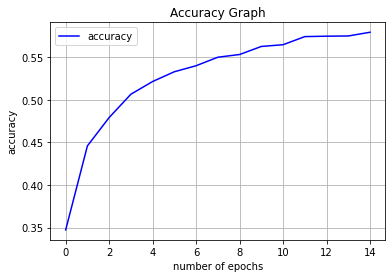

In [ ]:
plt.plot(history.history["accuracy"],color="b",label="accuracy")
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

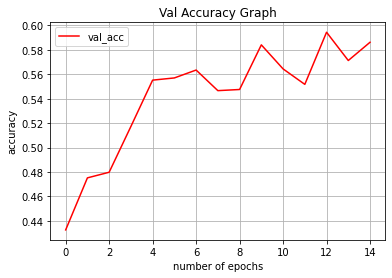

In [ ]:
plt.plot(history.history["val_accuracy"],color="r",label="val_acc")
plt.title("Val Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_vgg_16.evaluate(test_ds)

313/313 [==============================] - 52s 164ms/step - loss: 1.1927 - accuracy: 0.5766


[1.1926920413970947, 0.5766000151634216]

## Confusion Matrix

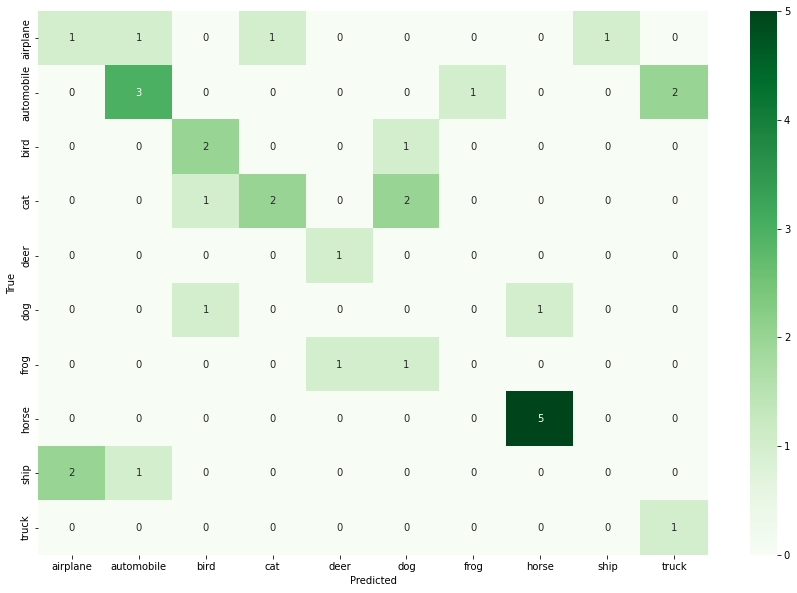

In [ ]:
#confusion matrix

for images, labels in train_ds.take(1): # first batch, 32 images and labels but considered only 1 loop
  y_pred = model_vgg_16.predict(images)
  y_true = labels


conf_mat = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))


f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="Greens")

class_names = train_ds.class_names

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()

# Transfer Model2 - VGG 16 (4 layers trainable)

### The model below (model_vgg_16_v2) is just like model_vgg_16 (the model above) but instead of last 2 layers, this model's last 4 layers are trainable. Check model.summary()

In [ ]:
IMG_SHAPE = (224, 224, 3)

VGG16_MODEL = tf.keras.applications.VGG16(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

#By specifying the include_top=False argument, you load a network that doesn’t include the classification layers.


model_vgg_16_v2 = tf.keras.Sequential([
    keras.Input(IMG_SHAPE),
    tf.keras.layers.Rescaling(1./255)
])

for layer in VGG16_MODEL.layers[:-1]: # go through until last layer
    model_vgg_16_v2.add(layer)
    layer.trainable = False

model_vgg_16_v2.layers[-1].trainable = True
model_vgg_16_v2.layers[-2].trainable = True

    
model_vgg_16_v2.add(Dense(1024))
model_vgg_16_v2.add(Activation("relu"))

model_vgg_16_v2.add(Dense(10))
model_vgg_16_v2.add(Activation("softmax"))


#tensorboard_vgg_16_v2 = TensorBoard(log_dir=f"logs/vgg_16_v2 batch={batch_size} epoch={Epoch}")

model_vgg_16_v2.compile(optimizer="Adam", 
              loss="categorical_crossentropy",
              metrics=["accuracy"])


model_vgg_16_v2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 rescaling (Rescaling)       (None, 224, 224, 3)       0         
                                                                 
 input_1 (InputLayer)        multiple                  0         
                                                                 
 block1_conv1 (Conv2D)       (None, 224, 224, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 224, 224, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 112, 112, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 112, 112, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 112, 112, 128)     1

In [ ]:
history = model_vgg_16_v2.fit(train_ds, epochs=Epoch, validation_data=valid_ds) #callbacks=[tensorboard_vgg_16]

Epoch 1/15
1094/1094 [==============================] - 292s 262ms/step - loss: 1.4280 - accuracy: 0.5192 - val_loss: 0.9396 - val_accuracy: 0.6645
Epoch 2/15
1094/1094 [==============================] - 285s 260ms/step - loss: 0.9189 - accuracy: 0.6781 - val_loss: 0.8697 - val_accuracy: 0.7025
Epoch 3/15
1094/1094 [==============================] - 284s 260ms/step - loss: 0.7930 - accuracy: 0.7269 - val_loss: 0.7211 - val_accuracy: 0.7485
Epoch 4/15
1094/1094 [==============================] - 284s 260ms/step - loss: 0.7075 - accuracy: 0.7550 - val_loss: 0.6961 - val_accuracy: 0.7581
Epoch 5/15
1094/1094 [==============================] - 284s 259ms/step - loss: 0.6370 - accuracy: 0.7792 - val_loss: 0.6730 - val_accuracy: 0.7701
Epoch 6/15
1094/1094 [==============================] - 284s 259ms/step - loss: 0.5850 - accuracy: 0.7987 - val_loss: 0.7400 - val_accuracy: 0.7588
Epoch 7/15
1094/1094 [==============================] - 284s 259ms/step - loss: 0.5446 - accuracy: 0.8112 - val_

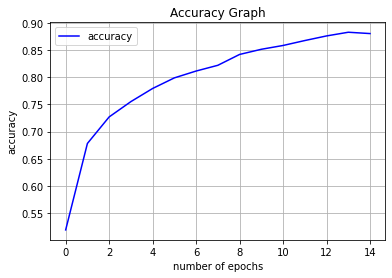

In [ ]:
plt.plot(history.history["accuracy"],color="b",label="accuracy")
plt.title("Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

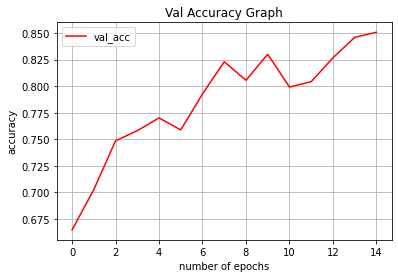

In [ ]:
plt.plot(history.history["val_accuracy"],color="r",label="val_acc")
plt.title("Val Accuracy Graph")
plt.xlabel("number of epochs")
plt.ylabel("accuracy")
plt.legend()
plt.grid()
plt.show()

In [ ]:
model_vgg_16_v2.evaluate(test_ds)

313/313 [==============================] - 54s 171ms/step - loss: 1.1097 - accuracy: 0.7415


[1.1096854209899902, 0.7415000200271606]

## Confusion Matrix

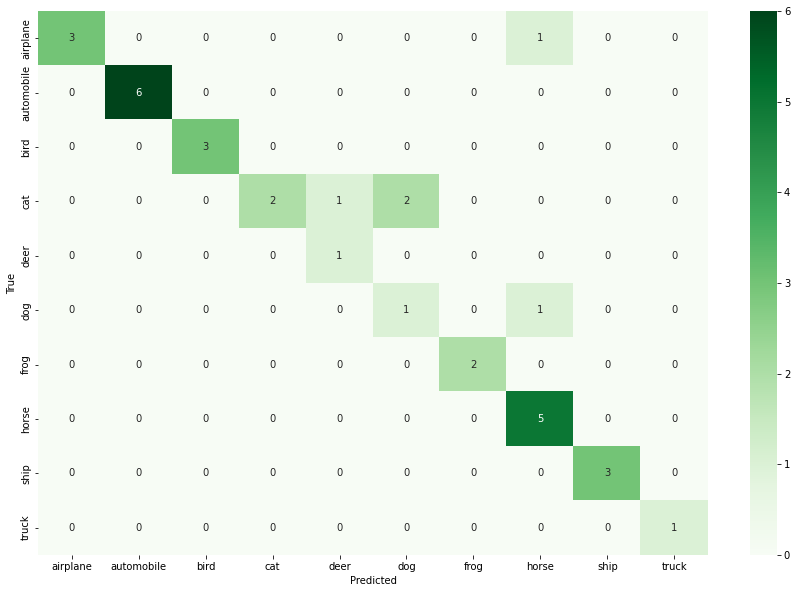

In [ ]:
#confusion matrix

for images, labels in train_ds.take(1): # first batch, 32 images and labels but considered only 1 loop
  y_pred = model_vgg_16_v2.predict(images)
  y_true = labels


conf_mat = confusion_matrix(np.argmax(y_true, axis=1), np.argmax(y_pred, axis=1))


f,ax=plt.subplots(figsize=(15,10))
sns.heatmap(conf_mat, annot=True, fmt='.0f', cmap="Greens")

class_names = train_ds.class_names

ax.set_xticklabels(class_names)
ax.set_yticklabels(class_names)

plt.xlabel("Predicted")
plt.ylabel("True")

plt.show()